In [1]:
# Import required libraries 
import json
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
import random
import itertools
from tensorflow import keras
from imblearn.under_sampling import RandomUnderSampler
print(tf.version.VERSION)


2.1.0


Import data and split into train, test and validation datasets

In [48]:
# %cd ../

# with zipfile.ZipFile('./breast-histopathology-images.zip', 'r') as zip_f:
#   zip_f.extractall()

path = './IDC_regular_ps50_idx5'
image_dir = []

for root, dir, files in os.walk(path):
    for file in files:
            image_dir.append(os.path.join(root, file))

In [49]:
labels = []

for img in image_dir:
    temp = img.split('/')
    labels.append(temp[-2])    

In [32]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(directory=path,
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(50, 50),
                                                     class_mode='binary',
                                                    classes=['0','1'])


Found 0 images belonging to 2 classes.


In [27]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

In [30]:
image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)
print(label_batch[0])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [50]:
image_dir = np.asarray(image_dir).reshape(-1,1)
labels = [float(y) for y in labels]
# labels = np.asarray(labels).reshape(-1,1)

In [51]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(image_dir, labels)

In [56]:
df = pd.DataFrame(data=X_resampled)
df.head()
df.to_csv("under_sampled.csv")

[0.]


In [12]:
def parse_image(img, lbl):
    image = tf.io.read_file(img)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 50])
    return image, lbl
# tf.strings.to_number(label,out_type=tf.dtypes.int32)

def preprocess_image(img, lbl):
    image = tf.image.random_flip_left_right(img)
    image = tf.image.random_flip_up_down(img)
    return image, lbl

def show_image(img, lbl):
    plt.figure()
    plt.imshow(img)
    plt.title(tf.strings.as_string(lbl))
    plt.axis('off')

In [10]:
split_0 = int(0.8*len(X_resampled))
split_1 = int(0.1*len(X_resampled))
train_x = X_resampled[0][:split_0]
train_y = y_resampled[0][:split_0]
test_dir = X_resampled[split_0:split_1]
val_dir = X_resampled[split_1:]

In [28]:
dir_list = tf.data.Dataset.list_files('./IDC_regular_ps50_idx5/*/*/*.png')
data = dir_list.map(parse_image)
data.shuffle(len(image_dir), 1)
train_data = data.take(split_0).map(preprocess_image)
# train_data = train_data.batch(20)
temp_data = data.skip(split_0)
val_data = temp_data.skip(split_1)
test_data = temp_data.take(split_1)

NameError: name 'data' is not defined

In [17]:
data = tf.data.Dataset.from_tensor_slices((X_resampled[0], y_resampled[0])) 
data = data.map(parse_image)
train_data = data.take(split_0).map(preprocess_image)
# train_data = train_data.batch(20)
temp_data = data.skip(split_0)
val_data = temp_data.skip(split_1)
test_data = temp_data.take(split_1)

Plot an image to verify that processing was done correcty

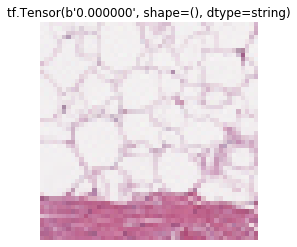

In [18]:
for image, label in train_data.take(1):
  show_image(image, label)
#   print(label)

In [19]:
class Model(tf.keras.Model):

  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', bias_initializer='he_normal')
    self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', bias_initializer='he_normal')
    self.max0 = tf.keras.layers.MaxPool2D(2,2)
    self.conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv5 = tf.keras.layers.Conv2D(128, 3, activation='relu')
    self.conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv7 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv8 = tf.keras.layers.Conv2D(256, 3, activation='relu')
    self.conv9 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv10 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv11 = tf.keras.layers.Conv2D(512, 3, activation='relu', bias_initializer='he_normal')
    self.conv12 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same", bias_initializer='he_normal')
    self.conv13 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same", bias_initializer='he_normal')
    # self.ave0 = tf.keras.layers.AveragePooling2D()
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(1000, activation='relu', use_bias= True, bias_initializer='he_normal')
    # self.b1 = tf.keras.layers.BatchNormalization(trainable=True)
    # self.d2 = tf.keras.layers.Dense(4096, activation='relu')
    # self.b2 = tf.keras.layers.BatchNormalization(trainable=True)
    self.d2 = tf.keras.layers.Dense(1, activation='sigmoid',  use_bias= True, bias_initializer='he_normal')

  def call(self, x):
    x = tf.reshape(x, [-1, 50, 50, 3])
    x = self.conv1(x)
    x = self.conv2(x)
    # x = self.b1(x)
    block_1 = self.max0(x)
    x = self.conv3(block_1)
    x = self.conv4(x)
    x = tf.keras.layers.add([x, block_1])
    block_2 = self.conv5(x)
    x = self.conv6(block_2)
    x = self.conv7(x)
    x = tf.keras.layers.add([x, block_2])
    block_3 = self.conv8(x)
    x = self.conv9(block_3)
    x = self.conv10(x)
    x = tf.keras.layers.add([x, block_3])
    block_4 = self.conv11(x)
    x = self.conv12(block_4)
    x = self.conv13(x)
    # x = self.max0(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return x

model = Model()

In [21]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(0.01)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

def train_step(images, labels):
  with tf.GradientTape() as tape:
    preds = model(images)
    loss = loss_function(labels, preds)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, preds)
  # print(train_accuracy.result())


def test_step(images, labels):
  with tf.GradientTape() as tape:
    preds = model(images)
#     labels = labels.numpy().decode('utf-8')
#     labels = float(labels)
    loss = loss_function(labels, preds)
    test_loss(loss)
    test_accuracy(labels, preds)


def val_step(images, labels):
  with tf.GradientTape() as tape:
    preds = model(images)
#     labels = labels.numpy().decode('utf-8')
#     labels = float(labels)
    loss = loss_function(labels, preds)
    val_loss(loss)
    val_accuracy(labels, preds)

epochs = 3

for epoch in range(epochs):
  for counter, (images, labels) in enumerate(train_data):
    train_step(images, labels)
    if counter % 55504 == 0 and counter!=0:
      print(f"Progress : {round(counter/len(image_dir)*100)}%, Training Accuracy : {train_accuracy.result()*100}")


  for val_images, val_labels in val_data:
    val_step(val_images, val_labels)

  print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()*100}, Validation Loss: {val_loss.result()}, Validation Accuracy: {val_accuracy.result()*100}')

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

Epoch 1, Loss: 0.0, Accuracy: 100.0, Validation Loss: 0.0, Validation Accuracy: 0.0
Epoch 2, Loss: 0.0, Accuracy: 100.0, Validation Loss: 0.0, Validation Accuracy: 0.0
Epoch 3, Loss: 0.0, Accuracy: 100.0, Validation Loss: 0.0, Validation Accuracy: 0.0
